In [87]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/beer_profile_and_ratings.csv')

features = ['ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol',
            'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices',
            'Malty',  'review_overall'] # 'review_aroma', 'review_appearance', 'review_palate', 'review_taste',
df = df[features].dropna()


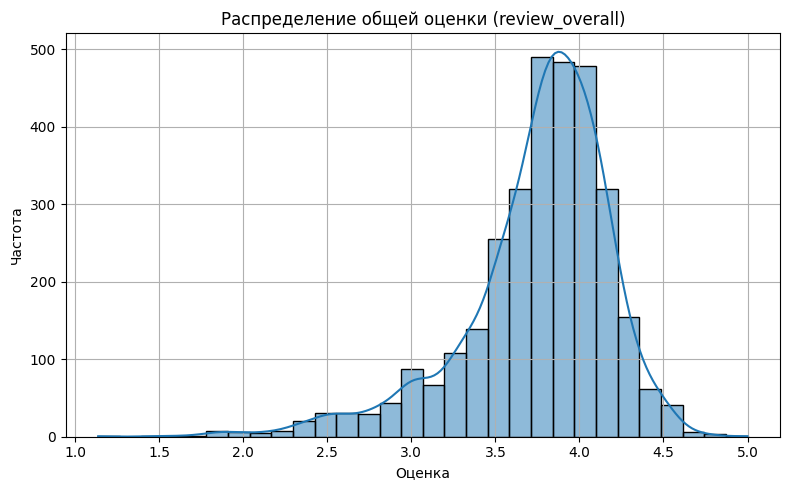

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['review_overall'], kde=True, bins=30)
plt.title("Распределение общей оценки (review_overall)")
plt.xlabel("Оценка")
plt.ylabel("Частота")
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

def remove_outliers_mahalanobis(df, threshold=0.95):
    x = df.values
    mean = np.mean(x, axis=0)
    cov = np.cov(x, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    distances = np.array([mahalanobis(row, mean, inv_cov) for row in x])
    cutoff = np.sqrt(chi2.ppf(threshold, df.shape[1]))
    return df[distances < cutoff]

df_clean = remove_outliers_mahalanobis(df)


In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_clean.drop("review_overall", axis=1)
y = df_clean["review_overall"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_all = LinearRegression()
model_all.fit(X_train, y_train)

y_pred_all = model_all.predict(X_test)
mse_all = mean_squared_error(y_test, y_pred_all)
r2_all = r2_score(y_test, y_pred_all)


In [91]:
import statsmodels.api as sm

def backward_elimination(X, y, sl=0.05):
    X = sm.add_constant(X)
    cols = list(X.columns)
    while True:
        model = sm.OLS(y, X[cols]).fit()
        p_values = model.pvalues
        max_p = p_values.max()
        if max_p > sl:
            excluded_feature = p_values.idxmax()
            cols.remove(excluded_feature)
        else:
            break
    return model, cols

model_be, selected_features = backward_elimination(X_train, y_train)

# Предсказание с выбранными признаками
X_test_be = sm.add_constant(X_test[selected_features[1:]])  # exclude 'const'
y_pred_be = model_be.predict(X_test_be)
mse_be = mean_squared_error(y_test, y_pred_be)
r2_be = r2_score(y_test, y_pred_be)


In [92]:
print("Полная модель:")
print(f"  MSE: {mse_all:.4f}")
print(f"  R²:  {r2_all:.4f}")

print("\nОптимизированная модель (Backward Elimination):")
print(f"  MSE: {mse_be:.4f}")
print(f"  R²:  {r2_be:.4f}")

print("\nВыбранные признаки:", selected_features)


Полная модель:
  MSE: 0.1332
  R²:  0.2825

Оптимизированная модель (Backward Elimination):
  MSE: 0.1334
  R²:  0.2818

Выбранные признаки: ['const', 'ABV', 'Min IBU', 'Astringency', 'Body', 'Alcohol', 'Sweet', 'Salty', 'Fruits', 'Spices', 'Malty']


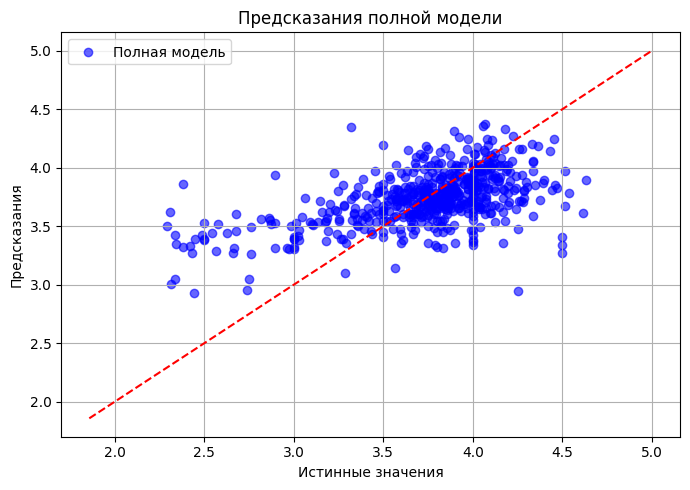

In [93]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred_all, alpha=0.6, color="blue", label="Полная модель")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title("Предсказания полной модели")
plt.xlabel("Истинные значения")
plt.ylabel("Предсказания")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

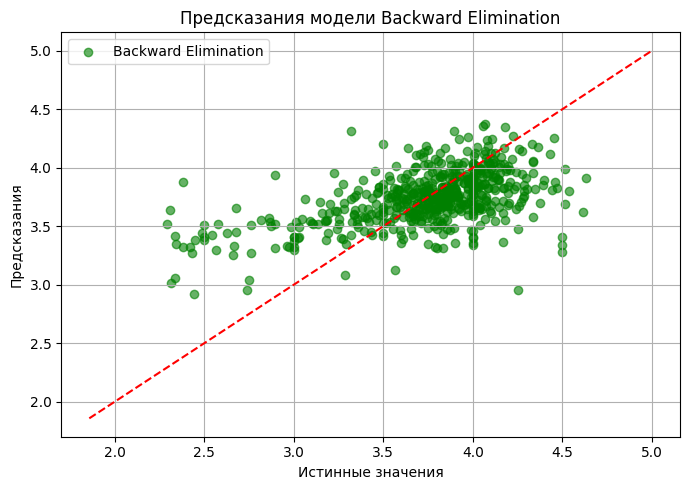

In [94]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred_be, alpha=0.6, color="green", label="Backward Elimination")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title("Предсказания модели Backward Elimination")
plt.xlabel("Истинные значения")
plt.ylabel("Предсказания")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

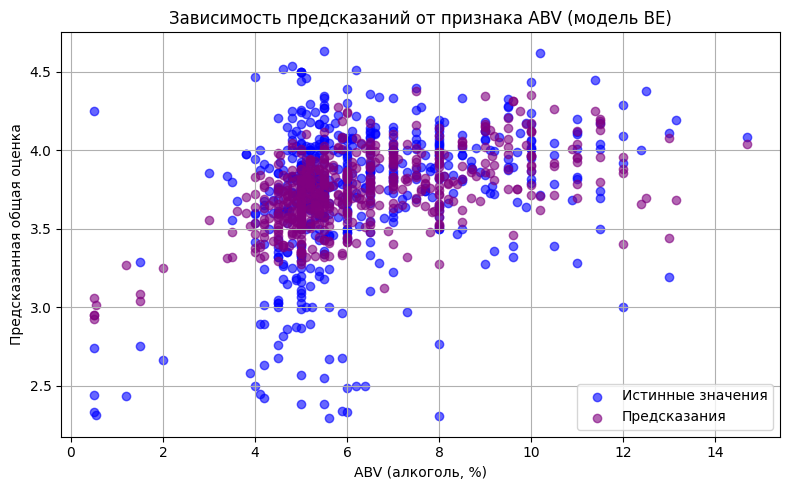

In [97]:
plt.figure(figsize=(8, 5))
plt.scatter(X_test['ABV'], y_test, alpha=0.6, color='blue', label='Истинные значения')
plt.scatter(X_test['ABV'], y_pred_be, alpha=0.6, color='purple', label='Предсказания')
plt.xlabel("ABV (алкоголь, %)")
plt.ylabel("Предсказанная общая оценка")
plt.title("Зависимость предсказаний от признака ABV (модель BE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()